In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

/Users/kaihanzhang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-07 12:30:20.228434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.chdir('/Users/kaihanzhang/Desktop/ML/MLWk10/dog')

In [3]:
data = pd.read_csv('dogs.csv')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9346 entries, 0 to 9345
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  9346 non-null   object
 1   labels     9346 non-null   object
 2   data set   9346 non-null   object
dtypes: object(3)
memory usage: 219.2+ KB


,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train
2,train/Afghan/003.jpg,Afghan,train
3,train/Afghan/004.jpg,Afghan,train
4,train/Afghan/005.jpg,Afghan,train


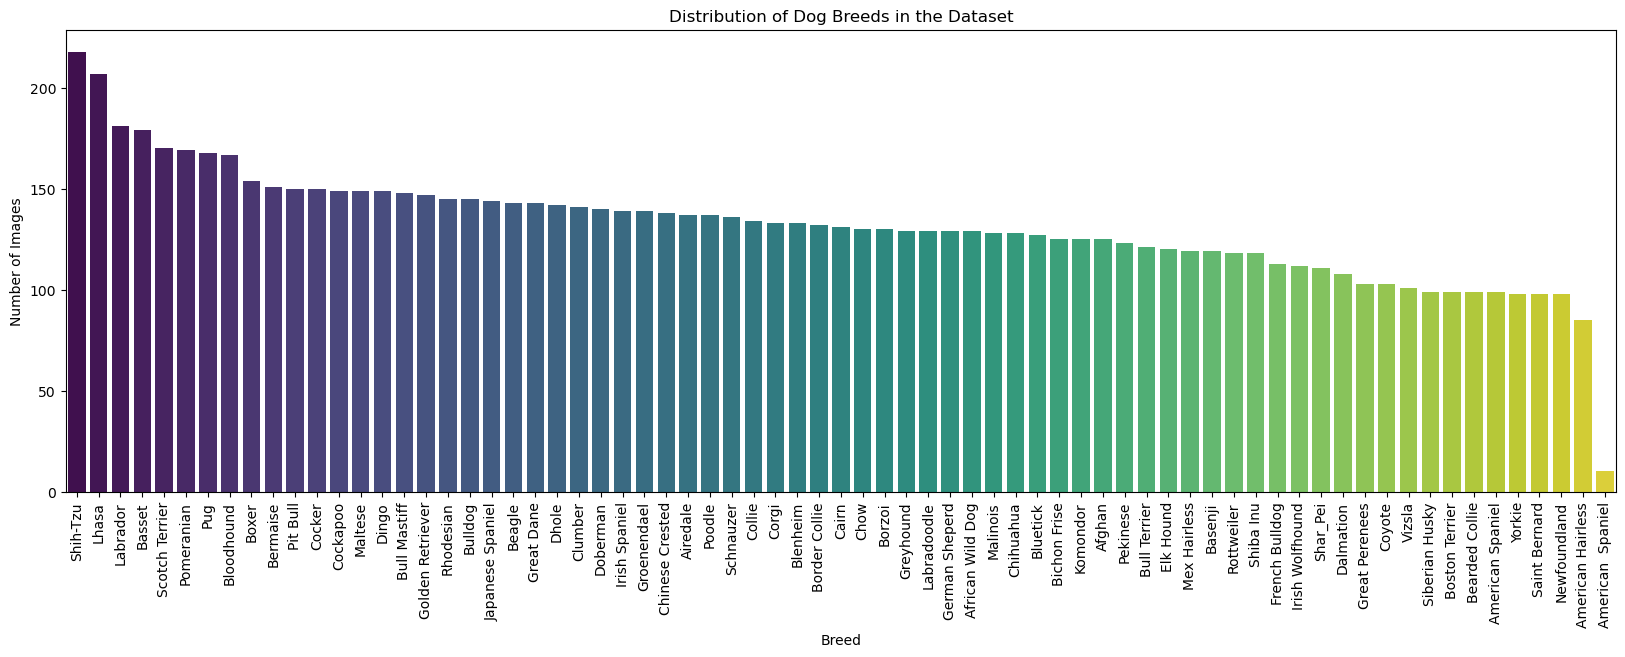

In [4]:
# Visualize the distribution of dog breeds
plt.figure(figsize=(20, 6))
breed_counts = data['labels'].value_counts()
sns.barplot(x=breed_counts.index, y=breed_counts.values, palette='viridis')
plt.title('Distribution of Dog Breeds in the Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Breed')
plt.xticks(rotation=90)
plt.show()

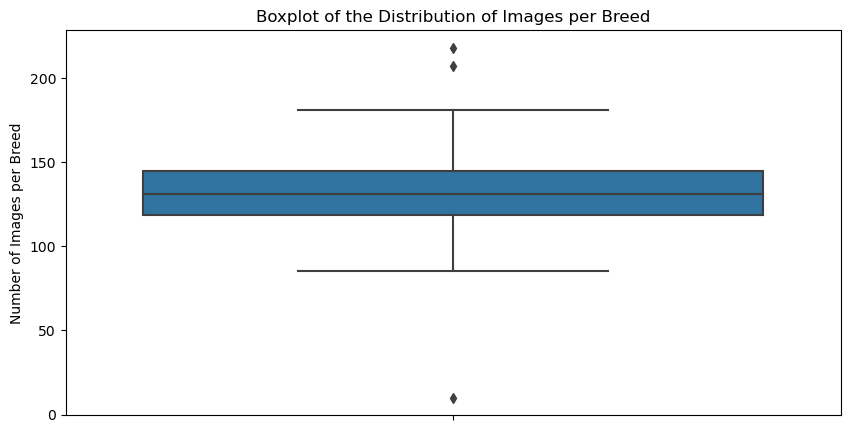

In [5]:
# Boxplot for class balance
plt.figure(figsize=(10, 5))
sns.boxplot(y=breed_counts.values)
plt.title('Boxplot of the Distribution of Images per Breed')
plt.ylabel('Number of Images per Breed')
plt.show()

In [6]:
# Data augmentation for training data and rescaling for validation and test data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Data generators
train_generator = train_datagen.flow_from_directory("train", target_size=(128, 128), batch_size=32, class_mode='categorical')
validation_generator = val_test_datagen.flow_from_directory("valid", target_size=(128, 128), batch_size=32, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory("test", target_size=(128, 128), batch_size=32, class_mode='categorical')

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


In [8]:
# Extract class names
class_names = list(train_generator.class_indices.keys())
n_classes = len(class_names)

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_indices = train_generator.class_indices

# Function to compute class weights (for handling class imbalance)
def get_class_weights(y, class_indices):
    # Map class labels to class indices
    label_to_index = {label: idx for label, idx in class_indices.items()}
    
    # Filter out labels not present in class_indices
    filtered_y = [label for label in y if label in label_to_index]

    # Convert class labels in filtered_y to class indices
    y_indices = np.array([label_to_index[label] for label in filtered_y])

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_indices), y=y_indices)

    # Map computed weights to the class indices used by the model
    return {label_to_index[label]: weight for label, weight in zip(np.unique(filtered_y), class_weights)}

class_weights = get_class_weights(data['labels'], class_indices)

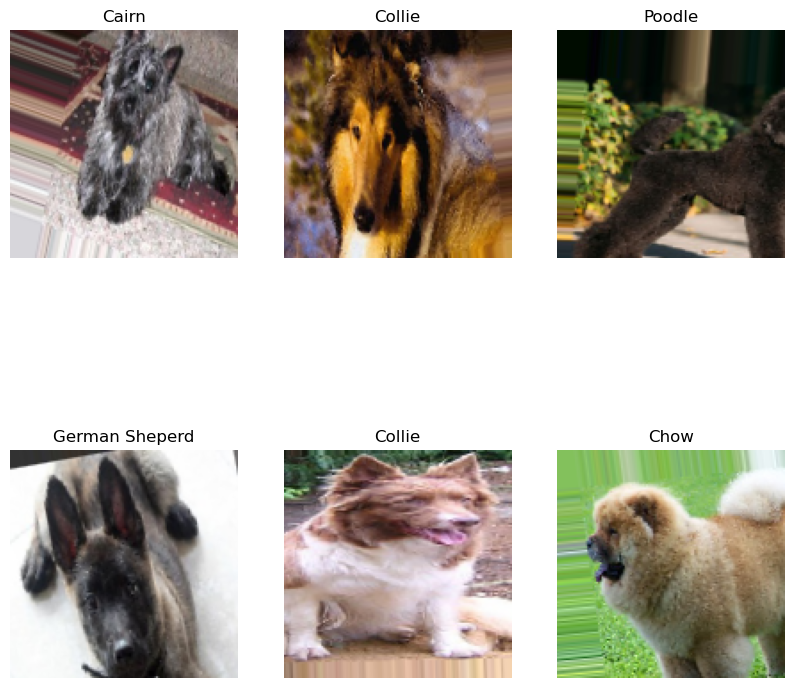

In [10]:
# Function to show images
def show_images(image_generator, class_names, num_images=6):
    image_batch, label_batch = next(image_generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i])
        label = label_batch[i]
        plt.title(class_names[np.argmax(label)])
        plt.axis("off")
    plt.show()
    
show_images(train_generator, class_names)

In [11]:
# Improved CNN Model Definition
def cnn_model(Width, Height, RGB, n_classes, lr):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(Width, Height, RGB)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Model parameters
image_size = 128
RGB = 3
lr = 0.0001

# Create the model
model = cnn_model(Width=image_size, Height=image_size, RGB=RGB, n_classes=n_classes, lr=lr)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True)


In [13]:
# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights
)

Epoch 1/100
249/249 [==============================] - 116s 461ms/step - loss: 4.2353 - accuracy: 0.0240 - val_loss: 4.2861 - val_accuracy: 0.0143
Epoch 2/100


/Users/kaihanzhang/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 110s 440ms/step - loss: 4.1054 - accuracy: 0.0405 - val_loss: 4.0555 - val_accuracy: 0.0571
Epoch 3/100
249/249 [==============================] - 109s 436ms/step - loss: 4.0331 - accuracy: 0.0502 - val_loss: 3.9389 - val_accuracy: 0.0757
Epoch 4/100
249/249 [==============================] - 108s 434ms/step - loss: 3.9812 - accuracy: 0.0564 - val_loss: 3.8747 - val_accuracy: 0.0800
Epoch 5/100
249/249 [==============================] - 110s 440ms/step - loss: 3.9167 - accuracy: 0.0710 - val_loss: 3.8042 - val_accuracy: 0.0771
Epoch 6/100
249/249 [==============================] - 110s 440ms/step - loss: 3.8721 - accuracy: 0.0751 - val_loss: 3.7340 - val_accuracy: 0.0986
Epoch 7/100
249/249 [==============================] - 111s 444ms/step - loss: 3.8262 - accuracy: 0.0756 - val_loss: 3.6958 - val_accuracy: 0.0914
Epoch 8/100
249/249 [==============================] - 109s 437ms/step - loss: 3.7772 - accuracy: 0.0814 - val_loss: 3.6860 - val_

In [17]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

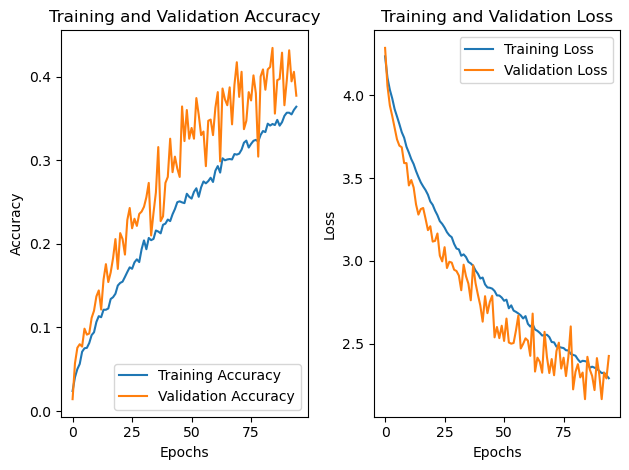

In [15]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Overfitting: If training accuracy is much higher than validation accuracy.
# Underfitting: If both training and validation accuracies are low.

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Overfitting: If training loss is much lower than validation loss.
# Underfitting: If both training and validation losses are high.

plt.tight_layout()
plt.show()

In [16]:
# Evaluate the model on the test set
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}")
print(f"Test Accuracy: {eval_result[1]}")
# Compare test set performance with training and validation to confirm overfitting or underfitting.

22/22 [==============================] - 3s 155ms/step - loss: 2.0732 - accuracy: 0.4357
Test Loss: 2.0732078552246094
Test Accuracy: 0.4357142746448517
